In [1]:
!curl -L https://www.dropbox.com/s/qsdq7sx946t39pa/amazon.tar?dl=1 -o amazon.tar

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100  637M  100  637M    0     0  35.1M      0  0:00:18  0:00:18 --:--:-- 41.1M


In [2]:
!tar xvf amazon.tar

Streaming output truncated to the last 5000 lines.
amazon/train-jpg/train_19718.jpg
amazon/train-jpg/train_38480.jpg
amazon/train-jpg/train_16787.jpg
amazon/train-jpg/train_621.jpg
amazon/train-jpg/train_28212.jpg
amazon/train-jpg/train_29928.jpg
amazon/train-jpg/train_30979.jpg
amazon/train-jpg/train_12790.jpg
amazon/train-jpg/train_37996.jpg
amazon/train-jpg/train_4564.jpg
amazon/train-jpg/train_423.jpg
amazon/train-jpg/train_15263.jpg
amazon/train-jpg/train_28557.jpg
amazon/train-jpg/train_17206.jpg
amazon/train-jpg/train_28792.jpg
amazon/train-jpg/train_12157.jpg
amazon/train-jpg/train_3899.jpg
amazon/train-jpg/train_34358.jpg
amazon/train-jpg/train_9458.jpg
amazon/train-jpg/train_15756.jpg
amazon/train-jpg/train_6353.jpg
amazon/train-jpg/train_2794.jpg
amazon/train-jpg/train_34451.jpg
amazon/train-jpg/train_11776.jpg
amazon/train-jpg/train_26449.jpg
amazon/train-jpg/train_15881.jpg
amazon/train-jpg/train_21669.jpg
amazon/train-jpg/train_31322.jpg
amazon/train-jpg/train_3449.jpg
am

In [1]:
import pandas as pd
import numpy as np
np.random.seed(0)

import cv2

from tqdm.notebook import tqdm
import os

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import fbeta_score
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt
import seaborn as sns

from functools import partial
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

import gc

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df_train = pd.read_csv('amazon/train_v2.csv')
df_train.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [0]:
img = cv2.imread('amazon/train-jpg/{}.jpg'.format('train_1'))

In [4]:
img.shape

(256, 256, 3)

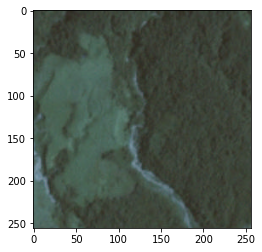

In [5]:
plt.imshow(img)
plt.show()

In [6]:
all_labels = df_train['tags'].map(lambda x: x.split(' ')).values
labels = list(set([y for x in all_labels for y in x]))

print( len(labels), labels )

17 ['agriculture', 'slash_burn', 'bare_ground', 'road', 'partly_cloudy', 'selective_logging', 'blow_down', 'conventional_mine', 'cultivation', 'primary', 'artisinal_mine', 'clear', 'habitation', 'water', 'cloudy', 'haze', 'blooming']


In [0]:
def read_data(df_train, labels, resize=(32, 32)):
    train_split = 5000
    test_split = 1000

    df_train = df_train[:train_split+test_split]
    X_train = []
    y_train = []

    label_map = {l: i for i, l in enumerate(labels)}
    inv_label_map = {i: l for l, i in label_map.items()}



    for f, tags in tqdm(df_train.values, miniters=1000):
        if False == os.path.exists('amazon/train-jpg/{}.jpg'.format(f)): continue

        img = cv2.imread('amazon/train-jpg/{}.jpg'.format(f))
        targets = np.zeros(len(label_map))
        for t in tags.split(' '):
            targets[label_map[t]] = 1 

        X_train.append(cv2.resize(img, resize))
        y_train.append(targets)
        
    y_train = np.array(y_train, np.uint8)
    X_train = np.array(X_train, np.float16) / 255.
    
    # split = 5000#35000

    
    # X_train, X_test, y_train, y_test
    return X_train[:train_split], X_train[train_split:train_split+test_split], y_train[:train_split], y_train[train_split:train_split+test_split]

def fbeta_score_K(y_true, y_pred):
    beta_squared = 4

    tp = K.sum(y_true * y_pred) + K.epsilon()
    fp = K.sum(y_pred) - tp
    fn = K.sum(y_true) - tp

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    result = (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())

    return result

def learning_curve(model_fit, key='acc', ylim=(0.5, 1.01)):
    plt.figure(figsize=(12,6))
    plt.plot(model_fit.history[key])
    plt.plot(model_fit.history['val_' + key])
    plt.title('Learning Curve')
    plt.ylabel(key.title())
    plt.xlabel('Epoch')
    plt.ylim(ylim)
    plt.legend(['train', 'test'], loc='best')
    plt.show()

In [8]:
if 'X_train' in locals(): del X_train
if 'X_test' in locals(): del X_test
if 'y_train' in locals(): del y_train
if 'y_test' in locals(): del y_test

X_train, X_test, y_train, y_test = read_data(df_train, labels, resize=(128, 128))

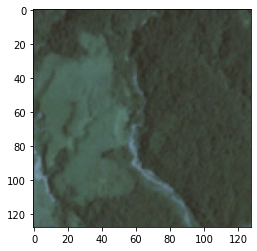

In [9]:
plt.imshow((X_train[1] * 255).astype(int))
plt.show()

In [10]:
X_train.shape

(5000, 128, 128, 3)

## Data analysis

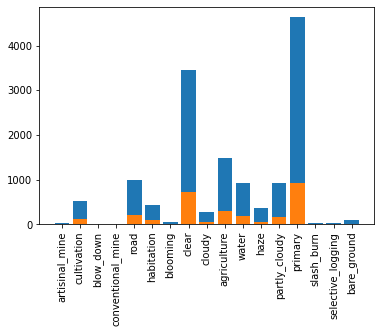

In [101]:
ax = plt.subplot(1,1,1)

plt.bar(range(len(labels)), y_train.sum(axis=0));
plt.bar(range(len(labels)), y_test.sum(axis=0));
plt.xticks(range(len(labels)), rotation=90);
ax.set_xticklabels(labels)

plt.show()


## Custom CNN

In [70]:
model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])),
        Conv2D(32, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),

        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),

        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),

        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(256, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),

        Flatten(), 

        Dense(1024, activation='relu'),        
        Dense(512, activation='relu'),
        Dense(17, activation='sigmoid') 
        ])


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[fbeta_score_K])
model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 126, 126, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 63, 63, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 61, 61, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 30, 128)     

Epoch 1/5
40/40 [==============================] - 15s 381ms/step - loss: 0.2521 - fbeta_score_K: 0.5580 - val_loss: 0.2416 - val_fbeta_score_K: 0.5776
Epoch 2/5
40/40 [==============================] - 14s 339ms/step - loss: 0.2363 - fbeta_score_K: 0.5811 - val_loss: 0.2247 - val_fbeta_score_K: 0.5982
Epoch 3/5
40/40 [==============================] - 14s 345ms/step - loss: 0.2235 - fbeta_score_K: 0.6021 - val_loss: 0.2699 - val_fbeta_score_K: 0.5559
Epoch 4/5
40/40 [==============================] - 14s 344ms/step - loss: 0.2231 - fbeta_score_K: 0.6073 - val_loss: 0.2131 - val_fbeta_score_K: 0.6148
Epoch 5/5
40/40 [==============================] - 14s 343ms/step - loss: 0.2151 - fbeta_score_K: 0.6144 - val_loss: 0.2147 - val_fbeta_score_K: 0.6455


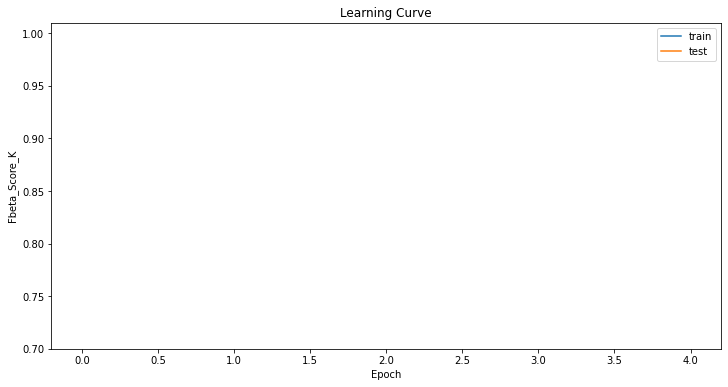

In [72]:
history = model.fit(X_train, y_train,
          batch_size=128,
          epochs=5,
          verbose=1,
          validation_data=(X_test, y_test))

learning_curve(history, 'fbeta_score_K')

## VGG

In [66]:
base_model = VGG16(weights='imagenet', include_top=False)
for layer in base_model.layers: # all blocked
  layer.trainable = False
    
for layer in base_model.layers[-4:]:
  layer.trainable = True
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [0]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

for layer in base_model.layers: # all blocked
  layer.trainable = False
    
for layer in base_model.layers[-4:]:
  layer.trainable = True

model = Sequential([
                    base_model,
                    Flatten(),

                    Dense(1024, activation='relu'),
                    Dropout(0.2),
                    Dense(512, activation='relu'),
                    Dropout(0.2),
                    Dense(17, activation='sigmoid')  
])
    
optimizer = Adam(0.0003, decay=0.000005)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[fbeta_score_K])
model.summary()

In [0]:
callbacks = [ 
    EarlyStopping(patience=10), #jeśli 4 epoki z rzędu nie ma poprawy, to zatrzymaj się
    ReduceLROnPlateau(patience=3), #jeśli 3 epoki z rzędu nie ma poprawy, zmniejsz krok (learning_rate)
]

history = model.fit(X_train, y_train,
          batch_size=128,
          epochs=150,
          verbose=1,
          validation_data=(X_test, y_test),
          callbacks = callbacks)

learning_curve(history, 'fbeta_score_K')

## Hyperparameter optimization

In [0]:
def test_model(base_model, step=0.0003, decay=0.000005):
  base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

  for layer in base_model.layers: # all blocked
    layer.trainable = False
      
  for layer in base_model.layers[-4:]:
    layer.trainable = True

  model = Sequential([
                      base_model,
                      Flatten(),

                      Dense(1024, activation='relu'),
                      Dropout(0.2),
                      Dense(512, activation='relu'),
                      Dropout(0.2),
                      Dense(17, activation='sigmoid')  
  ])
      
  optimizer = Adam(step, decay=decay)
  metric = fbeta_score_K
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[metric])

  callbacks = [ 
      EarlyStopping(patience=4),
  ]

  history = model.fit(X_train, y_train,
            batch_size=128,
            epochs=30,
            verbose=0,
            validation_data=(X_test, y_test),
            callbacks = callbacks)

  learning_curve(history, 'fbeta_score_K')

  return max(history.history['val_' + metric.__name__])

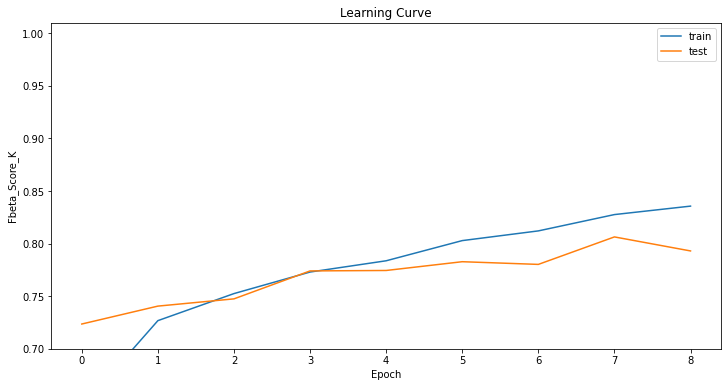


0.8063381314277649


In [106]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
score = test_model(base_model)
print()
print(score)

training wiht params: {'step': 0.009360159622018577, 'decay': 4.591050381344365e-05}
  0%|          | 0/20 [00:00<?, ?it/s, best loss: ?]

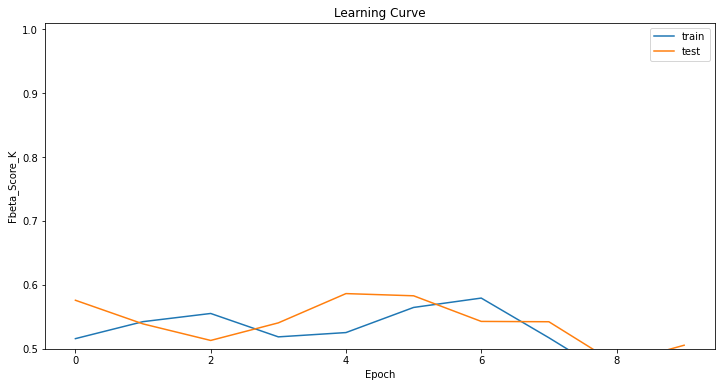

score: 0.5863211154937744

training wiht params: {'step': 0.003745519267438829, 'decay': 3.694382709811207e-05}
  5%|▌         | 1/20 [03:06<58:58, 186.22s/it, best loss: 0.5863211154937744]

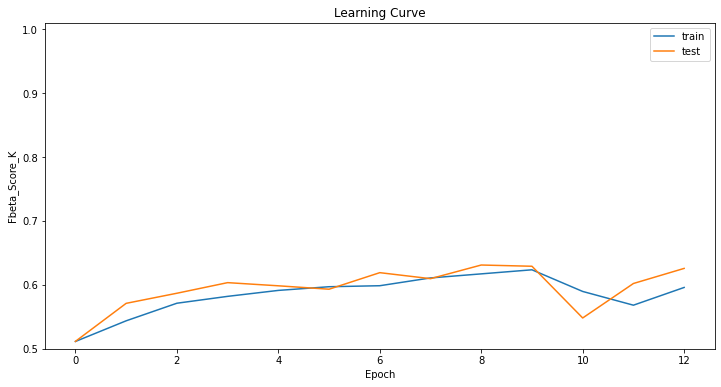

score: 0.6310042142868042

training wiht params: {'step': 0.003959329740752097, 'decay': 7.56255178039589e-05}
 10%|█         | 2/20 [07:06<1:00:46, 202.58s/it, best loss: 0.5863211154937744]

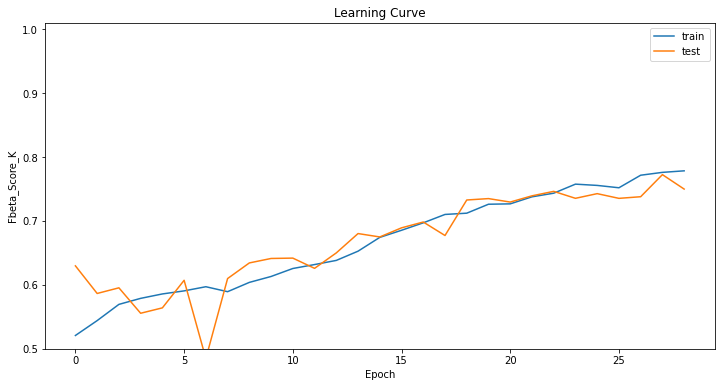

score: 0.7723278999328613

training wiht params: {'step': 0.0017467808918797375, 'decay': 8.905853606164792e-05}
 15%|█▌        | 3/20 [15:59<1:25:28, 301.66s/it, best loss: 0.5863211154937744]

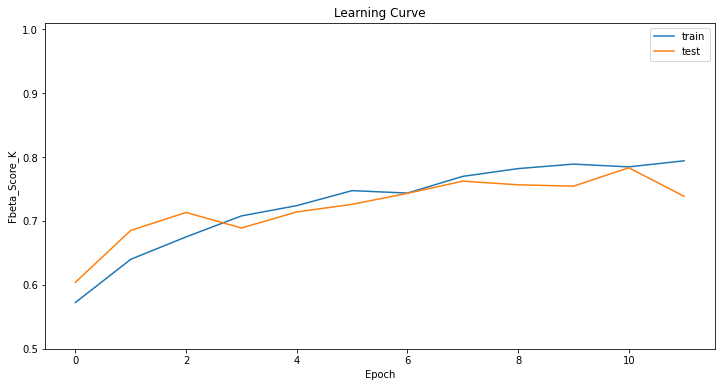

score: 0.7830443382263184

training wiht params: {'step': 0.006219445708412561, 'decay': 5.901492147227832e-05}
 20%|██        | 4/20 [19:42<1:14:09, 278.07s/it, best loss: 0.5863211154937744]

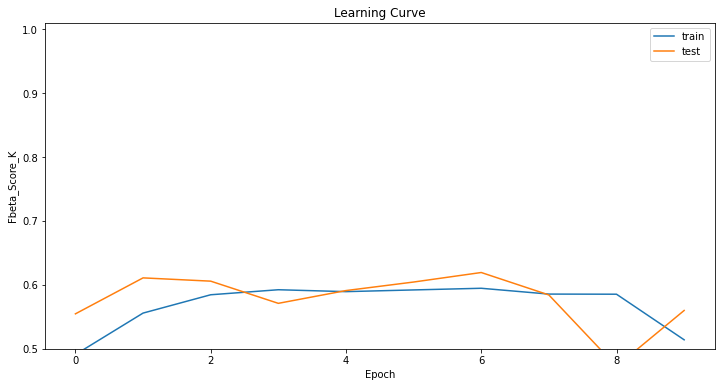

score: 0.6192887425422668

training wiht params: {'step': 0.00851661193196897, 'decay': 3.211574447790165e-06}
 25%|██▌       | 5/20 [22:49<1:02:41, 250.78s/it, best loss: 0.5863211154937744]

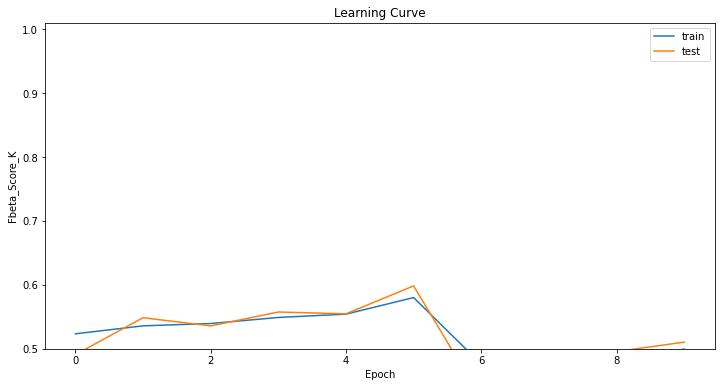

score: 0.5983543992042542

training wiht params: {'step': 0.009954939062100314, 'decay': 1.7849319345102823e-05}
 30%|███       | 6/20 [25:55<53:57, 231.27s/it, best loss: 0.5863211154937744]

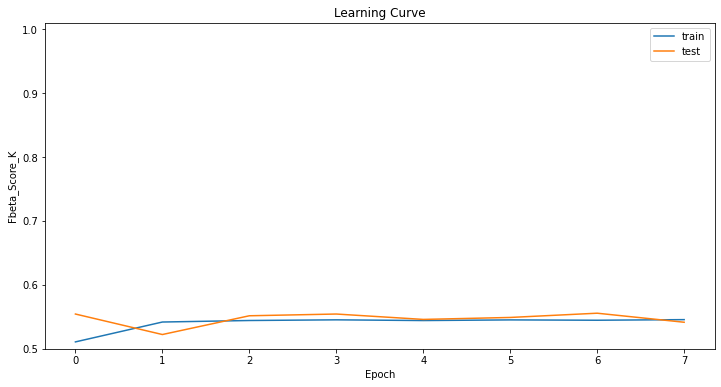

score: 0.5556615591049194

training wiht params: {'step': 0.00727669906879639, 'decay': 1.238194084344188e-06}
 35%|███▌      | 7/20 [28:25<44:47, 206.71s/it, best loss: 0.5556615591049194]

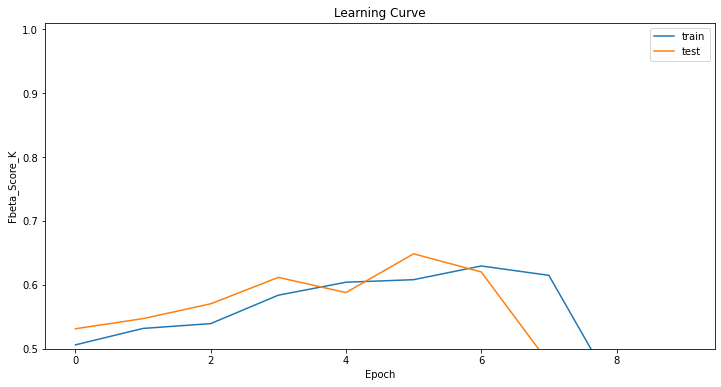

score: 0.6485302448272705

training wiht params: {'step': 0.00012957458449618531, 'decay': 2.2805732173707184e-05}
 40%|████      | 8/20 [31:31<40:05, 200.48s/it, best loss: 0.5556615591049194]

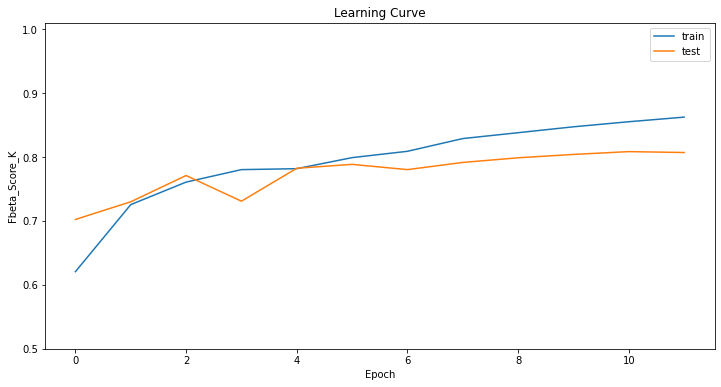

score: 0.8083288073539734

training wiht params: {'step': 0.009923977397034319, 'decay': 2.3026991334825897e-05}
 45%|████▌     | 9/20 [35:15<38:04, 207.65s/it, best loss: 0.5556615591049194]

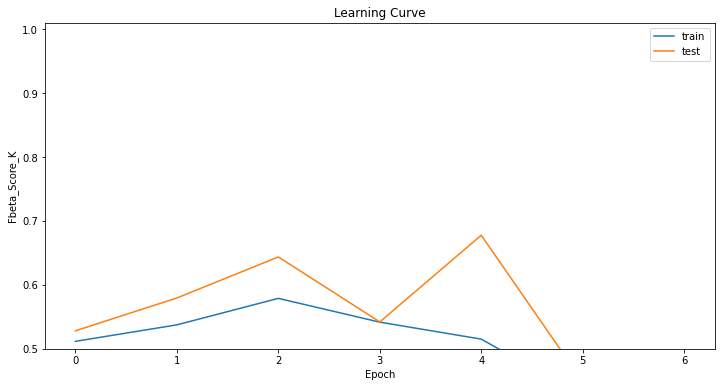

score: 0.6775985360145569

training wiht params: {'step': 0.0072835871460284664, 'decay': 9.865548219890918e-05}
 50%|█████     | 10/20 [37:26<30:47, 184.76s/it, best loss: 0.5556615591049194]

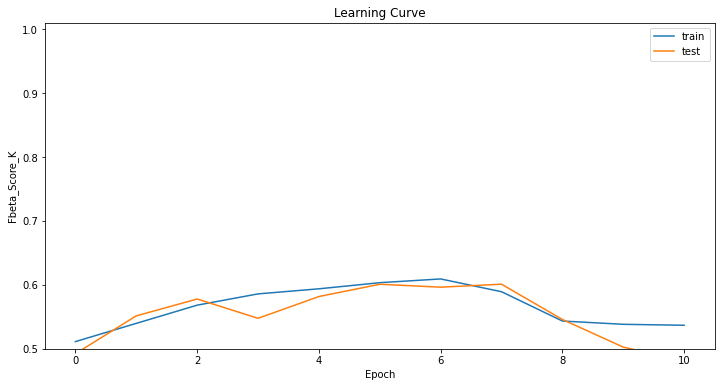

score: 0.6010218858718872

training wiht params: {'step': 0.005249583744479651, 'decay': 1.9217825174819434e-05}
 55%|█████▌    | 11/20 [40:51<28:35, 190.65s/it, best loss: 0.5556615591049194]

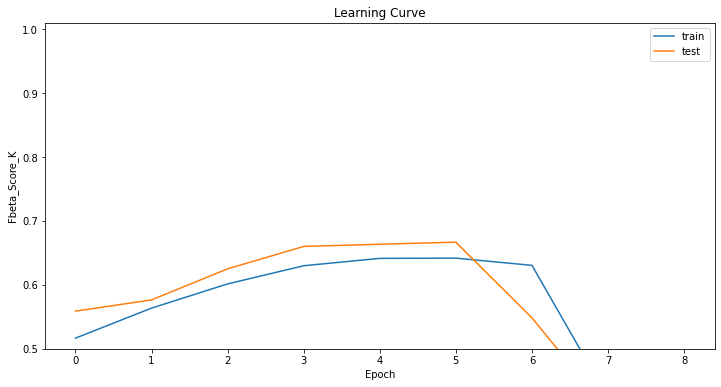

score: 0.6667333841323853

training wiht params: {'step': 0.009978727901454399, 'decay': 6.455786847598885e-05}
 60%|██████    | 12/20 [43:39<24:31, 183.90s/it, best loss: 0.5556615591049194]

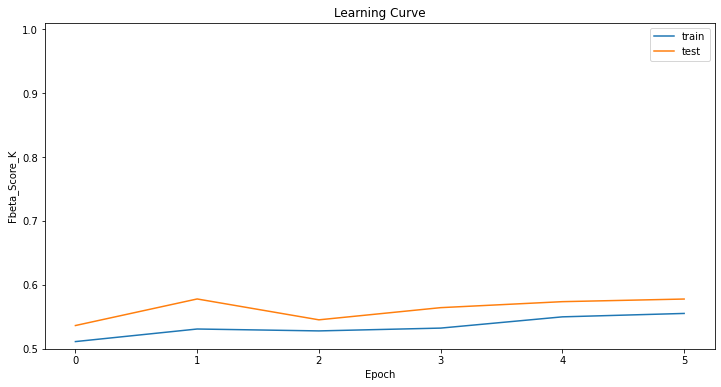

score: 0.5779299736022949

training wiht params: {'step': 0.0018482990511087573, 'decay': 1.0310315093409787e-05}
 65%|██████▌   | 13/20 [45:33<19:00, 162.96s/it, best loss: 0.5556615591049194]

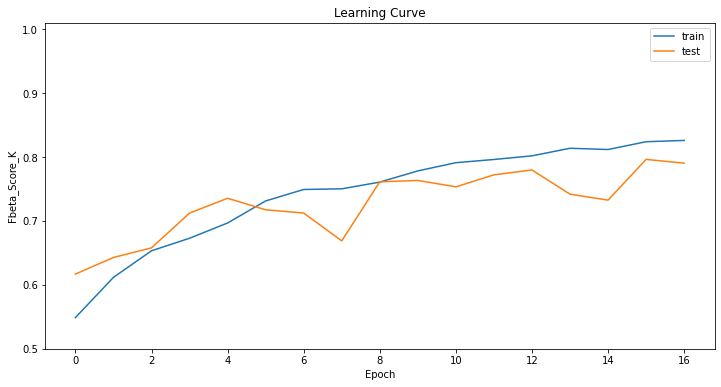

score: 0.7961641550064087

training wiht params: {'step': 0.00832502574237788, 'decay': 3.664563431391925e-05}
 70%|███████   | 14/20 [50:48<20:52, 208.70s/it, best loss: 0.5556615591049194]

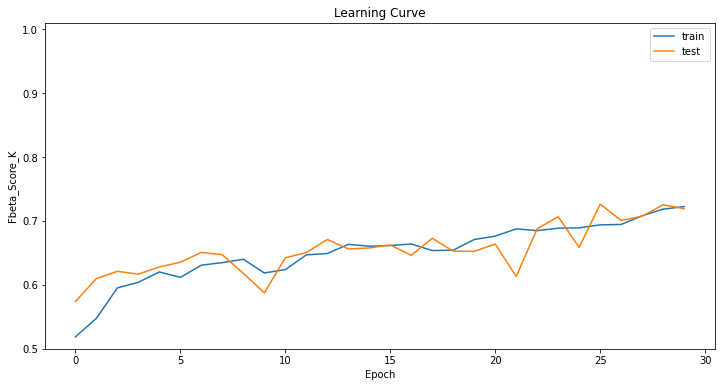

score: 0.7262279987335205

training wiht params: {'step': 0.005826069645538768, 'decay': 7.742560751393822e-05}
 75%|███████▌  | 15/20 [1:00:00<25:58, 311.68s/it, best loss: 0.5556615591049194]

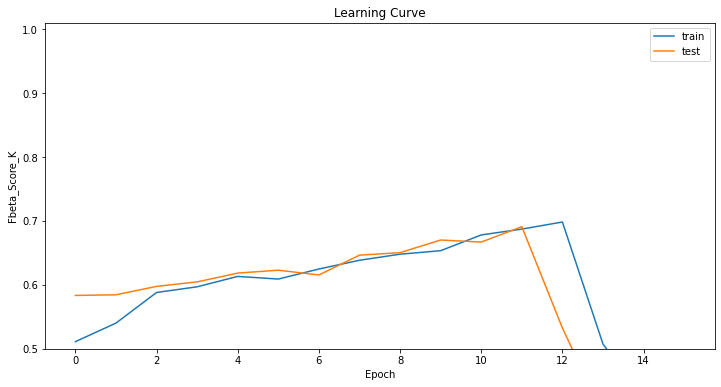

score: 0.6909005641937256

training wiht params: {'step': 0.003922475020385938, 'decay': 3.505541177501608e-05}
 80%|████████  | 16/20 [1:04:57<20:28, 307.04s/it, best loss: 0.5556615591049194]

In [0]:
# def test_model(base_model, step=0.0003, decay=0.000005):

def objective(space):

    params = {
        'step': space['step'],
        'decay': space['decay'],
    }

    print('training wiht params: {}'.format(params))
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    score = test_model(base_model, **params)
    
    print('score: {}\n'.format(score))
    return{'loss':score, 'status': STATUS_OK }

space ={
    'step': hp.uniform ('step', 0.0001, 0.01),
    'decay': hp.uniform ('decay', 0.000001, 0.0001),
}


trials = Trials()
best_params = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=5),
            max_evals=20,
            trials=trials)

print("The best params: ", best_params)